# Analysis and Feature Selection

This notebook will analyise the energy load data used for the model. A contents of the analysis contained is described below.

## Analysis of energy load data
1. Plot the energy load data as a whole
    - Yearly line plot / box plot
    - Grouped by months line plot / box plot
    - Grouped by days of the week mean / box plot
    
2. Repeat section 1 with each of the hourly slices.
    - Divided by year line plot / box plot
    - Grouped by months line plot / box plot
    - Grouped by days of the week mean / box plot

3. Investigate stationarity of hourly segments
    - Why look at indivdual segments?
    - Plot of the distributions
    - Skew and kurtosis tests for normality + explanation of what this means
    - Augmented Dicky Fuller test per hourly segment + as a whole
    - Autoregressive plot and partial auto regressive plot (hourly + as a whole)
    - Differencing in preparation for modelling with ARIMAX 

## Analysis of features
1. Plots of weather temperature/humidity versus consumption
    - Yearly line plot
2. Plots of moving averages
    - MA 7, 14, 21, etc.
    - Multi plot of MAs for each hourly timeslice
3. Correlation plots of:
    - heat maps + pairplots
    - Autoregressive features + moving averages
    - Weather predictors









Summary of problem definition points to investigate. 
1. Inputs vs. Outputs: What are the inputs and outputs for a forecast?
2. Endogenous vs. Exogenous: What are the endogenous and exogenous variables?
3. Unstructured vs. Structured: Are the time series variables unstructured or structured?
4. Regression vs. Classification: Are you working on a regression or classification predictive modeling problem? What are some alternate ways to frame your time series forecasting problem?
5. Univariate vs. Multivariate: Are you working on a univariate or multivariate time series problem?
6. Single-step vs. Multi-step: Do you require a single-step or a multi-step forecast?
7. Static vs. Dynamic: Do you require a static or a dynamically updated model?
8. Contiguous vs. Discontiguous: Are your observations contiguous or discontiguous?


In [43]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

## Energy Data: Overview

Objective is to understand the structure of the energy load data as a whole. Questions that help guide us are:

- What is the level, and noise varance, does the data contain any seasonal, or trending parts?
- Is the data stationary? If not can we make it stationary?
- What relationship is there between months and days of the year?
- What differences are there between the actual load and the predicted loads from Spain's TSO?

1. Plot the energy load data as a whole
    - Yearly line plot / box plot
    - Grouped by months line plot / box plot
    - Grouped by days of the week mean / box plot

In [65]:
#load the energy data
energy_data = pd.read_csv('./data/cleaned_data/energy_loads_2015_2019.csv', parse_dates=True, index_col='time')
energy_data.head()

day_forecast  actual_load
time                                          
2015-01-01 00:00:00       26118.0      25385.0
2015-01-01 01:00:00       24934.0      24382.0
2015-01-01 02:00:00       23515.0      22734.0
2015-01-01 03:00:00       22642.0      21286.0
2015-01-01 04:00:00       21785.0      20264.0

In [8]:
#statistical profile of loads
energy_data.describe()

day_forecast   actual_load
count  40752.000000  40752.000000
mean   28723.051593  28810.539286
std     4543.510301   4585.291397
min    18105.000000  18041.000000
25%    24877.000000  24896.000000
50%    28868.000000  29062.500000
75%    32182.250000  32403.000000
max    41390.000000  41015.000000

On inital inspection we see that the current short-term forecasts capture the same distribution as the actual. We see this in both their respective levels and inter quartile ranges. 

- Level of the forecasts is 28723 MWh
- Level of acutal demand is 28810 MWh

In supplying energy demand we are also interested in the baseload. The baseload is defined as the minimum demand over a period of time (usually weekly). In this case our global baseload is the minimum over the 4.5 years of data.
- Baseload is 18000 MWh

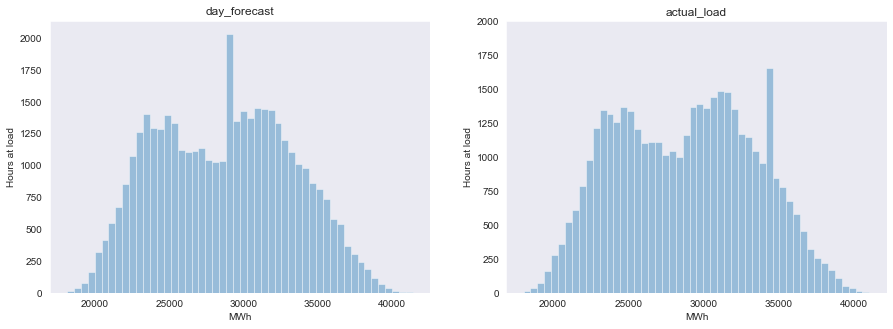

In [66]:
#visualize the distributions

fig, axs = plt.subplots(1, 2, figsize=(15,5))

#cycle through subplots and columns
for ax, col in zip(axs, energy_data.columns):
    #histogram plot
    sns.distplot(energy_data[col], ax=ax, kde=False, hist=True)
    #set axis labels
    ax.set_title(col)
    ax.set_xlabel('MWh')
    ax.set_ylabel('Hours at load')
    #set the y labels
    ax.set_yticks(np.linspace(0, 2000, 9))
    
plt.show()

Both actual and forecast load are bimodal distributions.

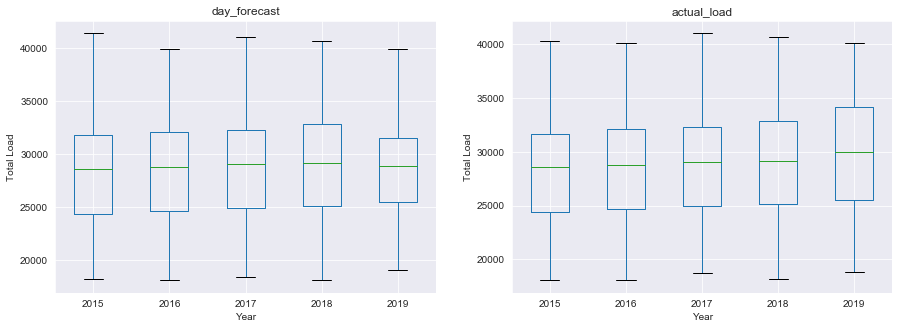

In [85]:
#group the data into years for plotting

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    groups = energy_data[col].groupby(pd.Grouper(freq='Y'))

    df = pd.DataFrame()

    for name, group in groups:
        df[name.year] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Load')
    ax.set_title(col)

Yearly variability in the distributions is consistent in terms of the IQRs and median values. There appears a small trend of rising median actual load from 2015 to 2018.

There are no outliers as would be expected (an outlier in energy distribution would be a shortage or excess of power, both resulting in grid imbalance and high risk of downtime).

Only 2019 shows a larger IQR however this might be explained with only the ~5500 hours of load data availale at time of analysis.

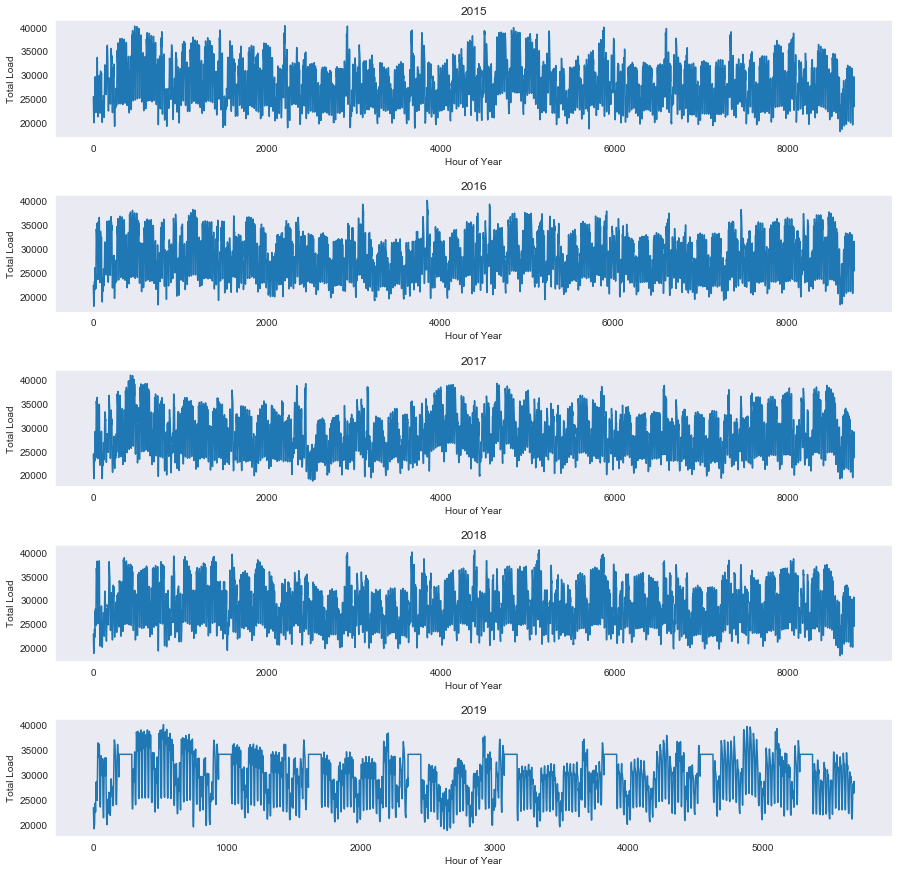

In [106]:
##### Plot the yearly actual loads

#group data by year
groups = energy_data['actual_load'].groupby(pd.Grouper(freq='Y'))

#set figure and axis
fig, axs = plt.subplots(len(groups), 1, figsize=(15,15))


for ax, (name, group) in zip(axs, groups):
    
    #plot the data
    ax.plot(pd.Series(group.values))

    ax.set_xlabel('Hour of Year')
    ax.set_ylabel('Total Load')
    ax.set_title(name.year)
    plt.subplots_adjust(hspace=0.5)

Looking at the global load any seasonality is not obvious. In the summers of 2015 and 2017 there appears a spike in overall consumption.

We also see some effects of the data cleaing in 2019. The imputation of Nans have left unrealistic load values for several hours. ***Check source data, this looks wrong***

##### Monthly demand variability

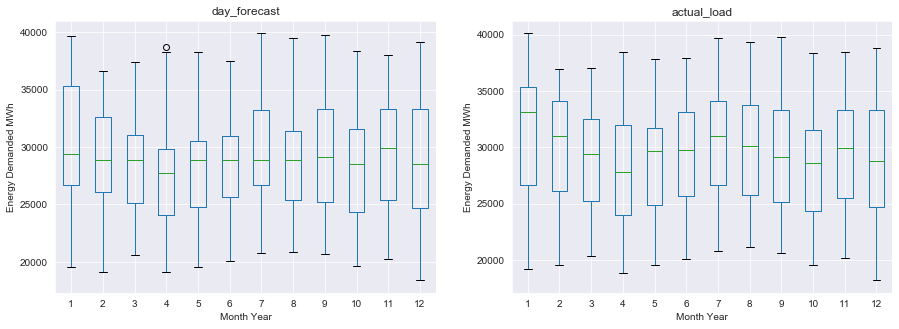

In [115]:
### plot the monthly demand variability. Looking for seasonal effects

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    
    groups = energy_data[col].groupby(pd.Grouper(freq='M'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.month] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Month Year')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
    
plt.show()

Actual loads shows clear seasonal trends through the year. This will have be investigated further when looking at the indivdual hourly slices for a multioutput forecast.

##### Weekly demand variability

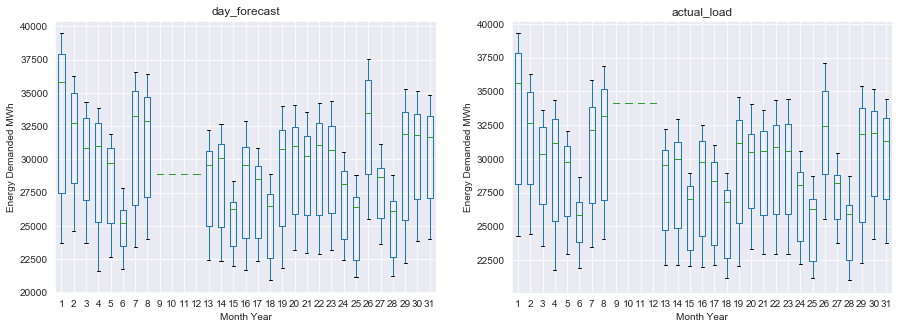

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    
    groups = energy_data[col].groupby(pd.Grouper(freq='D'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.day] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Month Year')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
    
plt.show()

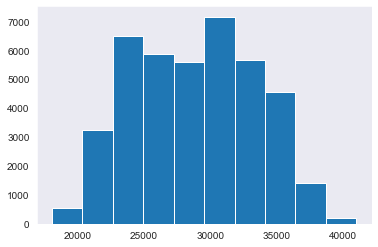

In [26]:
plt.hist(energy_data['actual_load']);

A time series is said to be stationary if it doesn’t increase or decrease with time linearly or exponentially(no trends), and if it doesn’t show any kind of repeating patterns(no seasonality)